# 🏫 Previsão de Evasão Escolar 
## 📚 Importando bibliotecas que serão utilizadas

In [13]:
import os
import sys
import numpy as np
from pathlib import Path
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn import model_selection
from IPython.display import Markdown
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
localizacao_reduzir_dados = os.path.join(os.getcwd(), '..')
sys.path.append(localizacao_reduzir_dados)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from tratamento_dados.reduzir_dados import reduzir_dados

## 🎲 Tratamento de Dados
#### 1. Trazer arquivo de dados de outras pastas.

In [2]:
data_folder = Path("../tratamento_dados/dados/")

ED_BRASILEIRA_2022_PATH = data_folder / 'ed_brasileira_2022.csv'
ED_BRASILEIRA_2022_REDU_PATH = data_folder / 'ed_brasileira_2022_redu.csv'

ed_brasileira_2022_redu_df = reduzir_dados(ED_BRASILEIRA_2022_PATH, ED_BRASILEIRA_2022_REDU_PATH)

c:\Users\gabri\Workspace\UFPB\2023.2\aprendizagem_maquina\evasao_escolar\src\tratamento_dados\dados_reduzidos.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ed_brasileira_2022_df = pd.read_csv(ED_BRASILEIRA_2022_PATH)
c:\Users\gabri\Workspace\UFPB\2023.2\aprendizagem_maquina\evasao_escolar\src\tratamento_dados\dados_reduzidos.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ed_brasileira_2022_redu_df = pd.read_csv(ED_BRASILEIRA_2022_REDU_PATH)


#### 2. Construir a matriz $X$ e o vetor $y$ de entrada para o classificador.

In [3]:
X = np.array(ed_brasileira_2022_redu_df.drop(['taxa_de_abandono'], axis=1))
y = np.array(ed_brasileira_2022_redu_df['taxa_de_abandono'])

#### 3. Identificar o número de exemplos ($N$) e número de features.

In [4]:
nRow = X.shape[0] 
nCol = X.shape[1]
display(Markdown(f"#### Número de exemplos ($N$): **{nRow}**, número de features: **{nCol}**."))

#### Número de exemplos ($N$): **19196**, número de features: **18**.

#### 4. Separar os dados ($X$, $y$) entre treinamento e teste.
- `RANDOM_STATE`: número que garante reprodutibilidade dos resultados, garantindo que a divisão dos dados em treinamento e teste seja a mesma toda vez que o código é executado.
- Tamanho do teste: 20%

In [5]:
RANDOM_STATE = 2 

X_train, X_test, y_train, y_test =  model_selection.train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

#### 5. Análise dos dados da função alvo.

(15356,)


(array([2726.,    0.,    0., 2748.,    0.,    0., 7141.,    0.,    0.,
        2741.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

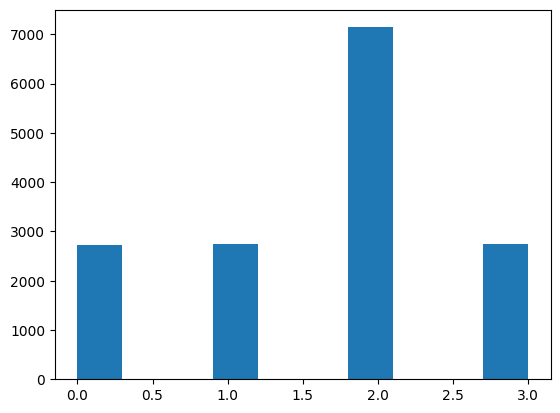

In [6]:
print(y_train.shape)
plt.hist(y_train)

##### 6.1. Como os dados estão desbalanceados, é necessário o processo de **undersampling** para balancear os dados, reduzindo aleatoriamente o tamanho da classe majoritária, até se assemelhar as outras classes, ajudando a prevenir o problema de o modelo de machine learning ser enviesado para a classe com mais dados.
- `random_state`: garante a reprodutibilidade dos resultados a partir da seed 42. 
- `sampling_strategy`: definindo a estratégia de amostragem como `majority` para que ocorra o processo nas amostras majoritárias. 
- uso de `fit_resample()` para aplicar o redimensinamento nos dados. 

In [7]:
balanceando_funcao_alvo = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_train, y_train = balanceando_funcao_alvo.fit_resample(X_train, y_train)

- Plotagem do balancemanto. 

(10941,)


(array([2726.,    0.,    0., 2748.,    0.,    0., 2726.,    0.,    0.,
        2741.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

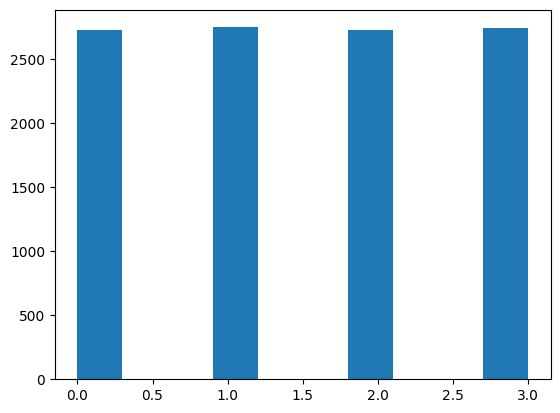

In [8]:
print(y_train.shape)
plt.hist(y_train)

## 🧠 Implementação do modelo baseado em Rede Neural
#### 1.  Definição da Arquitetura da Rede Neural 

In [9]:
DS, d = X_train.shape
quantidade_de_neuronios = int(abs((abs(DS) - 10)/(10*(d + 2))))
quantidade_de_neuronios

54

In [15]:
model = Sequential()
BATCH_SIZE = 128  
N_CLASSES = 4

model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # primeira camada escondida
model.add(Dense(quantidade_de_neuronios, kernel_initializer='normal', activation='relu'))
model.add(Dense(N_CLASSES, kernel_initializer='normal', activation='softmax')) # camada de saída

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               1900      
                                                                 
 dense_4 (Dense)             (None, 54)                5454      
                                                                 
 dense_5 (Dense)             (None, 4)                 220       
                                                                 
Total params: 7574 (29.59 KB)
Trainable params: 7574 (29.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
86/86 [==============================] - 1s 2ms/step - loss: 1.2776 - accuracy: 0.3790
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 1.1790 - accuracy: 0.4242
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 1.1679 -

- Performance do modelo

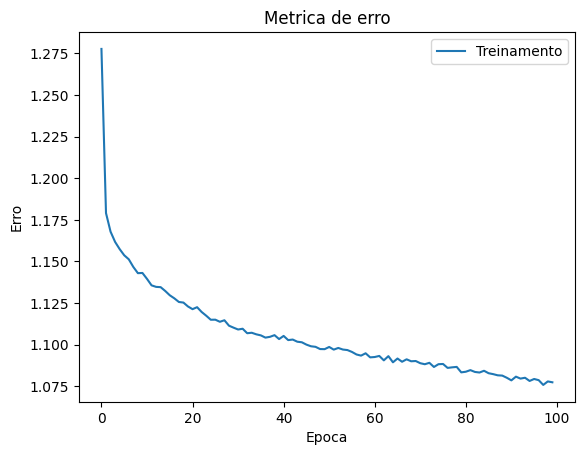

In [16]:
plt.plot(history.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

In [17]:
X_train, X_val, y_train, y_val =  model_selection.train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=0.2)

In [18]:
print(np.unique(y_val))

[0 1 2 3]


#### 1.2. Computar o *Ein* e *Eout* para analisar a existência de overfitting
- Calculando a validação do modelo

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=BATCH_SIZE)

Epoch 1/150
69/69 [==============================] - 0s 5ms/step - loss: 1.0759 - accuracy: 0.4961 - val_loss: 1.0812 - val_accuracy: 0.4751
Epoch 2/150
69/69 [==============================] - 0s 3ms/step - loss: 1.0724 - accuracy: 0.4922 - val_loss: 1.0848 - val_accuracy: 0.4788
Epoch 3/150
69/69 [==============================] - 0s 3ms/step - loss: 1.0739 - accuracy: 0.4898 - val_loss: 1.0919 - val_accuracy: 0.4774
Epoch 4/150
69/69 [==============================] - 0s 3ms/step - loss: 1.0727 - accuracy: 0.4958 - val_loss: 1.0900 - val_accuracy: 0.4829
Epoch 5/150
69/69 [==============================] - 0s 3ms/step - loss: 1.0710 - accuracy: 0.4998 - val_loss: 1.0894 - val_accuracy: 0.4833
Epoch 6/150
69/69 [==============================] - 0s 3ms/step - loss: 1.0703 - accuracy: 0.5008 - val_loss: 1.0903 - val_accuracy: 0.4824
Epoch 7/150
69/69 [==============================] - 0s 3ms/step - loss: 1.0695 - accuracy: 0.4992 - val_loss: 1.0928 - val_accuracy: 0.4778
Epoch 8/150
6

In [20]:
def plotar_acuracia_e_in_e_out(X_train, X_val, y_train, y_val, history):
    fig, ax = plt.subplots()
    
    # Plot training and validation loss
    ax.plot(history.history['loss'], label='Treinamento')
    ax.plot(history.history['val_loss'], label='Validação')
    
    # Set plot titles and labels
    ax.set_title('Métrica de Erro')
    ax.set_ylabel('Erro')
    ax.set_xlabel('Época')
    
    ax.legend()
    plt.show()

    pred_train = model.predict(X_train)
    pred_train_labels = np.argmax(pred_train, axis=1)

    pred_val = model.predict(X_val)
    pred_val_labels = np.argmax(pred_val, axis=1)

    acc_train = accuracy_score(y_train, pred_train_labels)
    acc_val = accuracy_score(y_val, pred_val_labels)

    print(f'--> Acurácia (treino): {acc_train:.6f}')
    print(f'--> Acurácia (validação): {acc_val:.6f}')

    print(f"acc_train - acc_val = {acc_train - acc_val:.6f}")
    print(f"E_val - E_in = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.6f}")

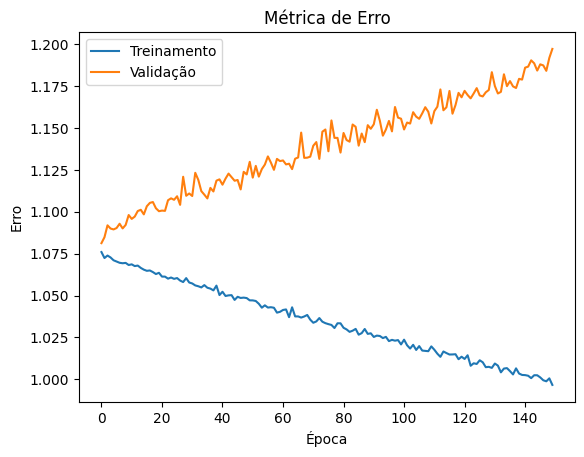

69/69 [==============================] - 0s 1ms/step
--> Acurácia (treino): 0.543990
--> Acurácia (validação): 0.450434
acc_train - acc_val = 0.093556
E_val - E_in = 0.200476


In [21]:
plotar_acuracia_e_in_e_out(X_train, X_val, y_train, y_val, history)

In [22]:
# Normalizacao de dados
min_values = X.min(axis=0)
max_values = X.max(axis=0)

X = (X - min_values) / (max_values - min_values)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=0.2)

#### Tratando a overfitting

In [23]:
from keras.callbacks import EarlyStopping

model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(quantidade_de_neuronios, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(N_CLASSES, kernel_initializer='normal', activation='softmax'))

# Treinamento COM Early Stopping

# val_loss = quantidade a ser monitorada, mode = o treinamento vai parar quando quando a quantidade monitorada parou de diminuir, 
# verbose = mostra a época em que parou de diminuir, patience = número de épocas que ainda são testadas depois do treinamento achar a melhor acurácia.
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               1900      
                                                                 
 dense_4 (Dense)             (None, 54)                5454      
                                                                 
 dense_5 (Dense)             (None, 4)                 220       
                                                                 
 dense_6 (Dense)             (None, 100)               500       
                                                                 
 dense_7 (Dense)             (None, 54)                5454      
                                                                 
 dense_8 (Dense)             (None, 4)                 220       
                                                                 
Total params: 13748 (53.70 KB)
Trainable params: 13748

In [24]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/150
96/96 [==============================] - 2s 6ms/step - loss: 1.2622 - accuracy: 0.4630 - val_loss: 1.0873 - val_accuracy: 0.4730
Epoch 2/150
96/96 [==============================] - 0s 3ms/step - loss: 1.0620 - accuracy: 0.4983 - val_loss: 1.0426 - val_accuracy: 0.5068
Epoch 3/150
96/96 [==============================] - 0s 3ms/step - loss: 1.0456 - accuracy: 0.5212 - val_loss: 1.0367 - val_accuracy: 0.5208
Epoch 4/150
96/96 [==============================] - 0s 3ms/step - loss: 1.0370 - accuracy: 0.5272 - val_loss: 1.0285 - val_accuracy: 0.5443
Epoch 5/150
96/96 [==============================] - 0s 3ms/step - loss: 1.0324 - accuracy: 0.5334 - val_loss: 1.0239 - val_accuracy: 0.5332
Epoch 6/150
96/96 [==============================] - 0s 3ms/step - loss: 1.0271 - accuracy: 0.5359 - val_loss: 1.0224 - val_accuracy: 0.5413
Epoch 7/150
96/96 [==============================] - 0s 3ms/step - loss: 1.0245 - accuracy: 0.5379 - val_loss: 1.0242 - val_accuracy: 0.5420
Epoch 8/150
9

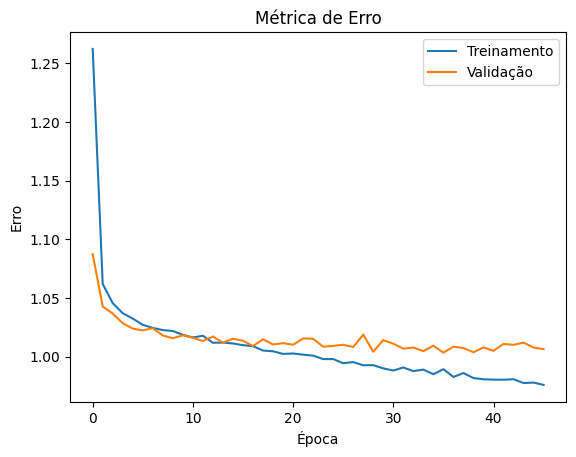

96/96 [==============================] - 0s 1ms/step
--> Acurácia (treino): 0.561706
--> Acurácia (validação): 0.545898
acc_train - acc_val = 0.015808
E_val - E_in = 0.030473


In [25]:
plotar_acuracia_e_in_e_out(X_train, X_val, y_train, y_val, history)

### Usando o K-Fold Cross Validation para validar o modelo usando todo o conjunto de treinamento

In [26]:
from keras import regularizers

# Configuração do StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

modelos_fold = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = Sequential([
        Dense(100, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.01), activation='relu'),
        Dense(quantidade_de_neuronios, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    dados_modelo = [X_train_fold, X_val_fold, y_train_fold, y_val_fold]
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=100, batch_size=BATCH_SIZE, verbose=1)
    
    modelos_fold.append((model, dados_modelo, history))

Epoch 1/100
96/96 [==============================] - 1s 4ms/step - loss: 1.8050 - accuracy: 0.4690 - val_loss: 1.4796 - val_accuracy: 0.5033
Epoch 2/100
96/96 [==============================] - 0s 3ms/step - loss: 1.3494 - accuracy: 0.5125 - val_loss: 1.2624 - val_accuracy: 0.5218
Epoch 3/100
96/96 [==============================] - 0s 3ms/step - loss: 1.2121 - accuracy: 0.5158 - val_loss: 1.1821 - val_accuracy: 0.5221
Epoch 4/100
96/96 [==============================] - 0s 4ms/step - loss: 1.1540 - accuracy: 0.5175 - val_loss: 1.1404 - val_accuracy: 0.5218
Epoch 5/100
96/96 [==============================] - 1s 6ms/step - loss: 1.1244 - accuracy: 0.5219 - val_loss: 1.1173 - val_accuracy: 0.5169
Epoch 6/100
96/96 [==============================] - 0s 3ms/step - loss: 1.1038 - accuracy: 0.5266 - val_loss: 1.1034 - val_accuracy: 0.5182
Epoch 7/100
96/96 [==============================] - 0s 4ms/step - loss: 1.0938 - accuracy: 0.5200 - val_loss: 1.0948 - val_accuracy: 0.5225
Epoch 8/100
9

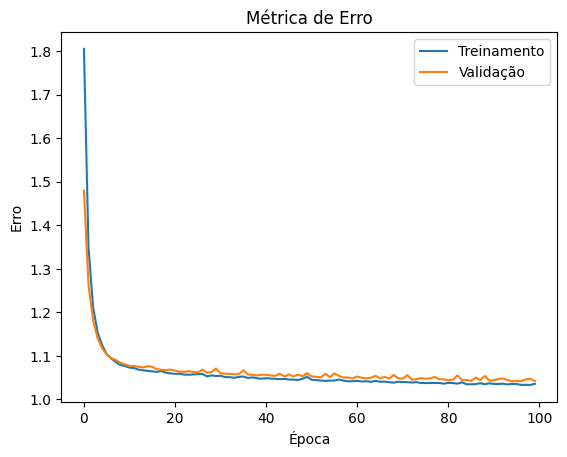

96/96 [==============================] - 0s 1ms/step
--> Acurácia (treino): 0.538261
--> Acurácia (validação): 0.539062
acc_train - acc_val = -0.000801
E_val - E_in = 0.006271


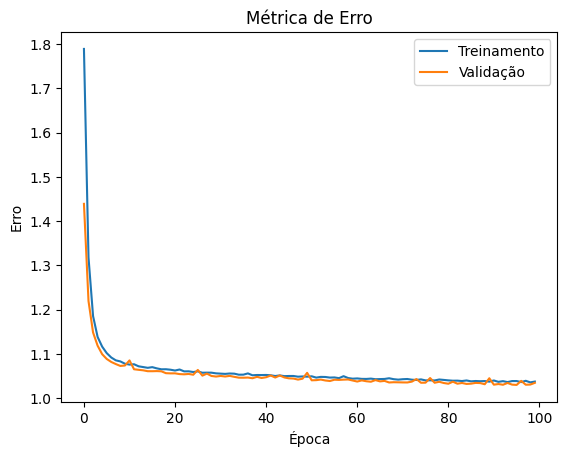

96/96 [==============================] - 0s 799us/step
--> Acurácia (treino): 0.537810
--> Acurácia (validação): 0.540866
acc_train - acc_val = -0.003056
E_val - E_in = -0.002862


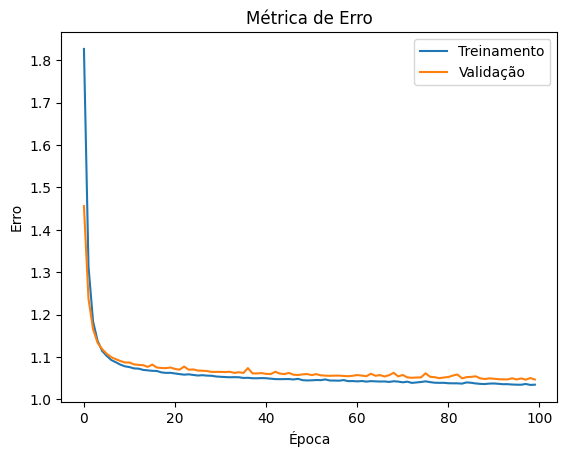

96/96 [==============================] - 0s 1ms/step
--> Acurácia (treino): 0.537648
--> Acurácia (validação): 0.541517
acc_train - acc_val = -0.003870
E_val - E_in = 0.012131


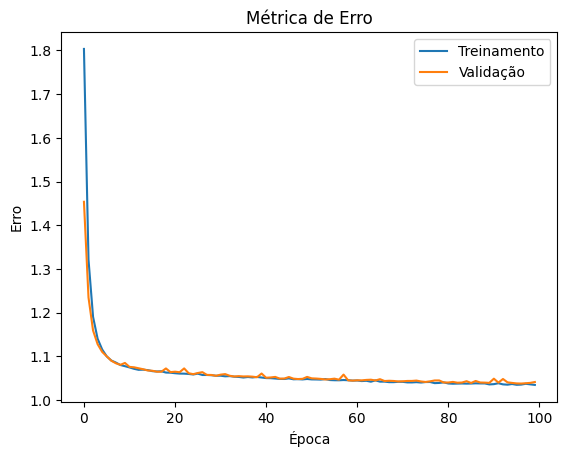

96/96 [==============================] - 0s 888us/step
--> Acurácia (treino): 0.538217
--> Acurácia (validação): 0.539238
acc_train - acc_val = -0.001021
E_val - E_in = 0.006641


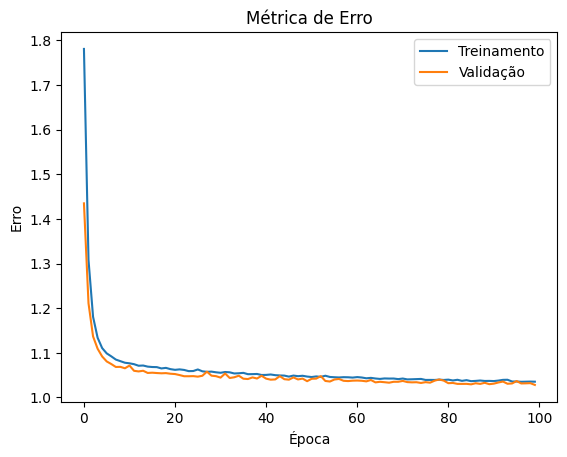

96/96 [==============================] - 0s 945us/step
--> Acurácia (treino): 0.540171
--> Acurácia (validação): 0.531423
acc_train - acc_val = 0.008748
E_val - E_in = -0.007253


In [28]:
for _, dados_modelo, history in modelos_fold:
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = dados_modelo     
    plotar_acuracia_e_in_e_out(X_train_fold, X_val_fold, y_train_fold, y_val_fold, history)

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

melhor_modelo = None
melhor_acuracia = 0.0

for modelo, dados_modelo, _ in modelos_fold:
    X_val, y_val = dados_modelo[1], dados_modelo[3]
    
    pred_val = model.predict(X_val)
    pred_val_labels = np.argmax(pred_val, axis=1)
    acc_val = accuracy_score(y_val, pred_val_labels)
    
    if acc_val > melhor_acuracia:
        melhor_acuracia = acc_val
        melhor_modelo = modelo

# Realizar predições no conjunto de teste
predictions = melhor_modelo.predict(X_test)
pred_test_labels = np.argmax(predictions, axis=1)

print(f'Acurácia do melhor modelo com dados de validação: {round(melhor_acuracia, 3)}')

120/120 [==============================] - 0s 1ms/step
Acurácia do melhor modelo com dados de validação: 0.542


In [60]:
accuracy = accuracy_score(y_test, pred_test_labels)
print(f'Acurácia do melhor modelo com dados de teste: {accuracy:.4f}')

precision = precision_score(y_test, pred_test_labels, average='macro')  # 'macro' ignora o desbalanceamento de classes
print(f'Precisão do melhor modelo com dados de teste: {precision:.4f}')

recall = recall_score(y_test, pred_test_labels, average='macro')
print(f'Recall do melhor modelo com dados de teste: {recall:.4f}')

f1 = f1_score(y_test, pred_test_labels, average='macro')
print(f'F1 Score do melhor modelo com dados de teste: {f1:.4f}')

Acurácia do melhor modelo com dados de teste: 0.5266
Precisão do melhor modelo com dados de teste: 0.3952
Recall do melhor modelo com dados de teste: 0.4128
F1 Score do melhor modelo com dados de teste: 0.3446


## Árvore de decisão

In [61]:
RANDOM_STATE = 2 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

### Construção de árvore de decisão com a instância de treino
### - Verificação de métricas do primeiro modelo
### - Computando os valores de E_in e E_out, verificando a ocorrência de overfitting

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

arvore = DecisionTreeClassifier()
arvore.fit(X_train, y_train)

E_in = (1 - accuracy_score(y_train, arvore.predict(X_train)))
E_out = (1 - accuracy_score(y_test, arvore.predict(X_test)))

print('E_in: %0.4f' % E_in)
print('E_out: %0.4f' % E_out)

print(f'E_out - E_in: {E_out - E_in}')

print(classification_report(y_test, arvore.predict(X_test)))

E_in: 0.3570
E_out: 0.4693
E_out - E_in: 0.11227682447686027
              precision    recall  f1-score   support

           0       0.34      0.42      0.38       662
           1       0.36      0.40      0.38       724
           2       0.73      0.78      0.76      1778
           3       0.26      0.13      0.17       676

    accuracy                           0.53      3840
   macro avg       0.42      0.43      0.42      3840
weighted avg       0.51      0.53      0.52      3840



#### Criação de função para plotagem da árvore

In [81]:
import pandas as pd
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

def plotar_arvore(arvore, X, y):
    plt.figure(figsize=(20,10))
    plot_tree(arvore, filled=True, feature_names=pd.DataFrame(X).columns, proportion=True, rounded=True, class_names=np.unique(y).astype(str))

    plt.show()

#### Primeira árvore possui impurezas

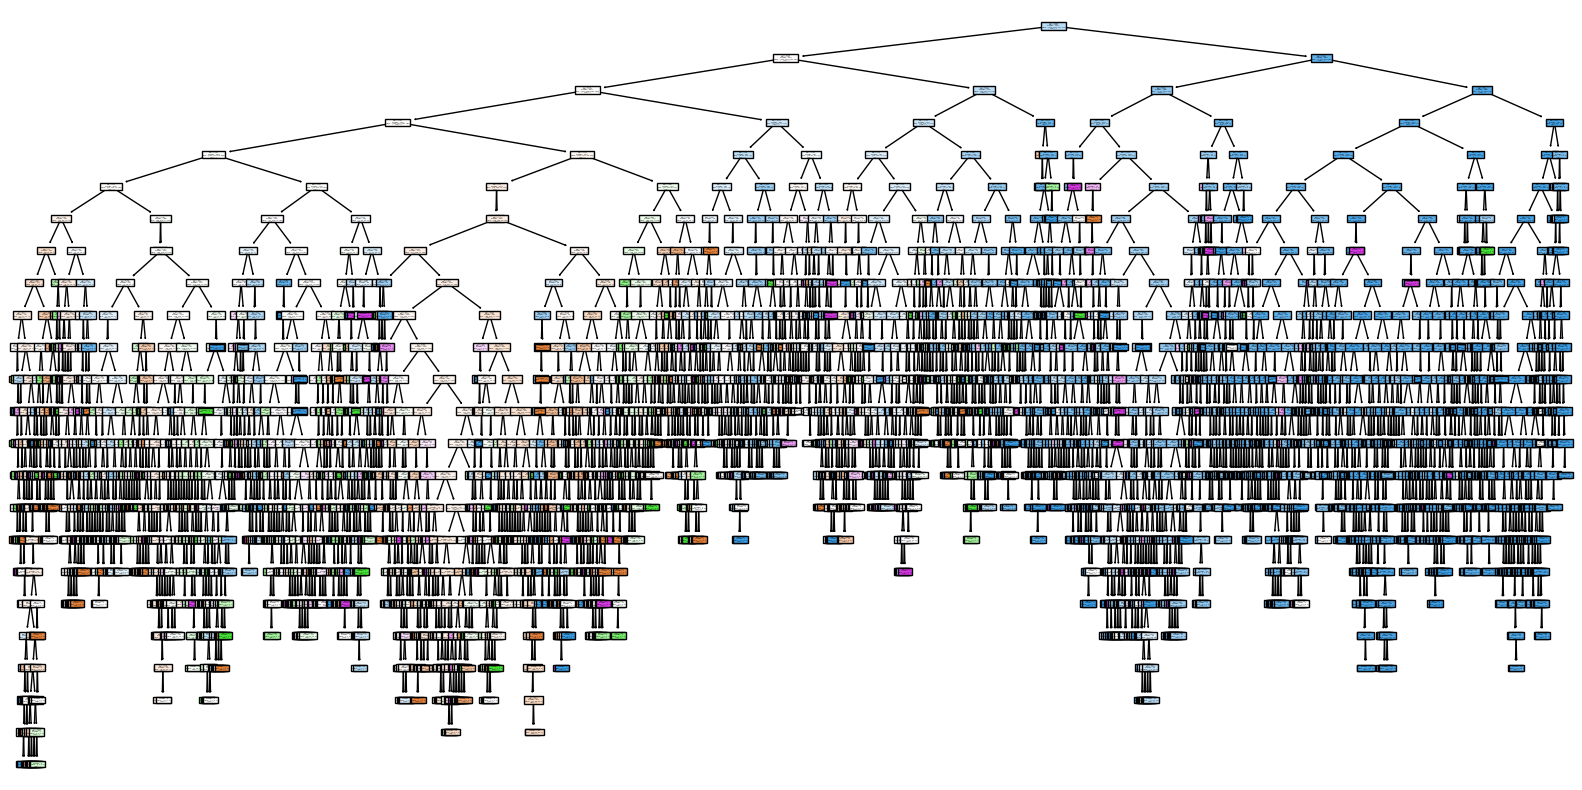

In [68]:
plotar_arvore(arvore, X, y)

#### Regularização do valor de alpha, os valores de alpha são iterados a fim de encontrar o melhor alpha, para tanto, utiliza-se o método `cost_complexity_pruning_path`, a técnica de validação cruzada é usada com o StratifiedKFold para encontrar a melhor árvore e o alpha que minimize a relação `Pureza(T) + alpha ∙ # folhas(T)`

In [76]:
from sklearn.model_selection import cross_val_score


caminhos = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurezas = caminhos.ccp_alphas, caminhos.impurities

skf = StratifiedKFold(n_splits=5, shuffle=True)
valores_alpha = []

for ccp_alpha in ccp_alphas:
    ccp_alpha = max(ccp_alpha, 0) 
    arvore = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=ccp_alpha)
    valores = cross_val_score(arvore, X_train, y_train, cv=skf, scoring='accuracy')
    valores_alpha.append(np.mean(valores))

### Obtenção do melhor valor de alpha

In [79]:
melhor_alpha = ccp_alphas[np.argmax(valores_alpha)]
melhor_arvore = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=melhor_alpha)
melhor_arvore.fit(X_train, y_train)

print(f'Melhor ccp_alpha: {melhor_alpha}')
print(f'Acurácia média maxima no Cross Validation: {max(valores_alpha):.4f}')

Melhor ccp_alpha: 0.00015081258097017405
Acurácia média maxima no Cross Validation: 0.5488


#### Plotar árvore e printar métricas da melhor árvore

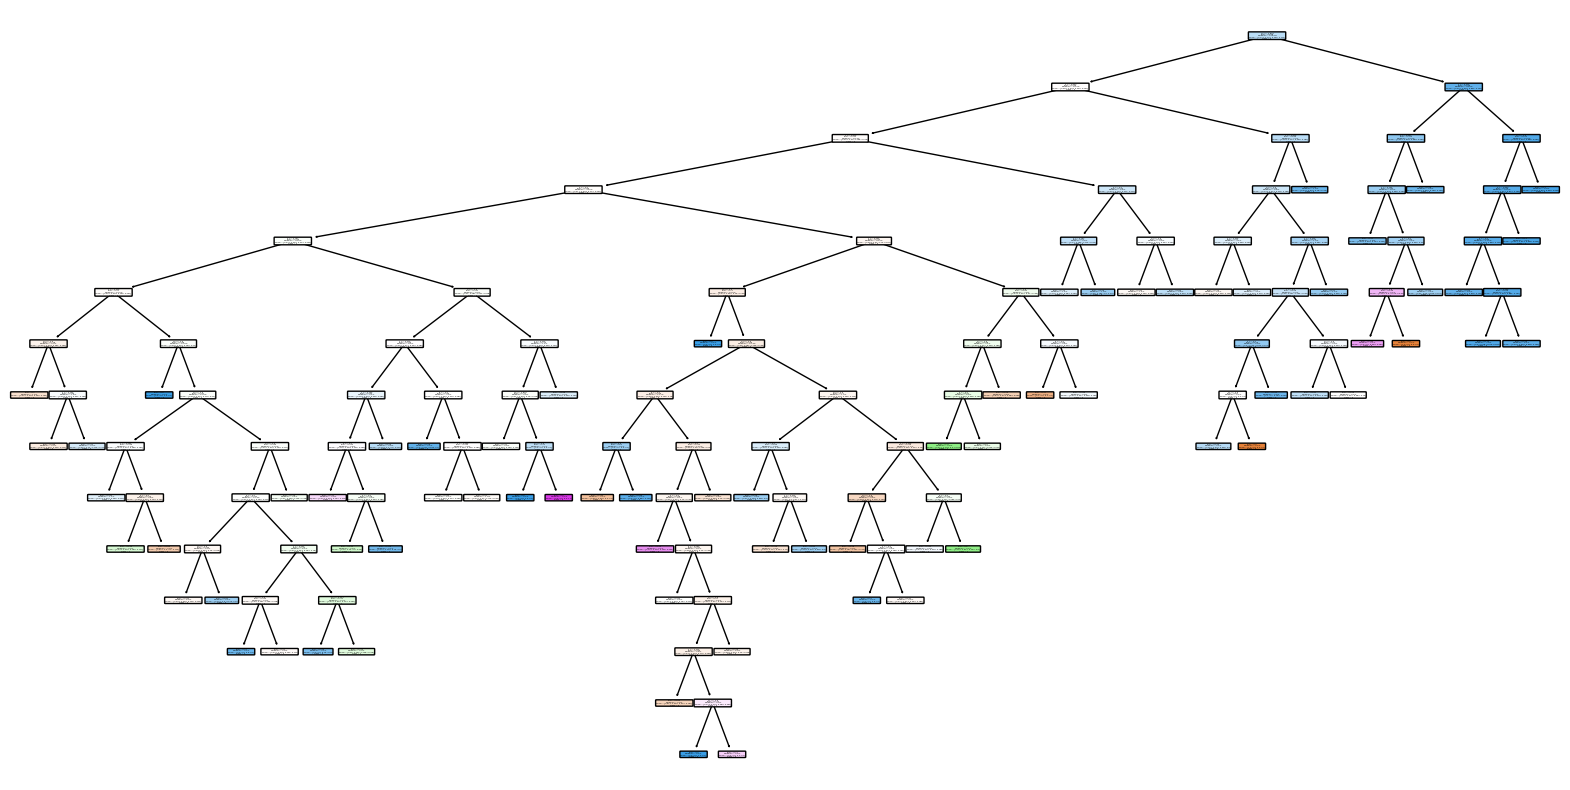

              precision    recall  f1-score   support

           0       0.36      0.55      0.44       662
           1       0.37      0.36      0.37       724
           2       0.72      0.84      0.77      1778
           3       0.24      0.01      0.02       676

    accuracy                           0.56      3840
   macro avg       0.42      0.44      0.40      3840
weighted avg       0.51      0.56      0.51      3840



In [82]:
plotar_arvore(melhor_arvore, X, y)

predictions = melhor_arvore.predict(X_test)
print(classification_report(y_test, predictions))